In [1]:
import os
import numpy as np
import cv2
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
directory = "TImages/"

In [3]:
image_size = (244, 244)
classes = ["0", "1", "2"]

In [4]:
# Create an ImageDataGenerator instance with data augmentation settings
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [5]:
training_data = []

def create_training_data():
    for category in classes:
        path = os.path.join(directory, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, image_size)

                # Generate and store augmented images
                augmented_images = []
                augmented_images.append(new_array)  # Original image
                img_array_aug = new_array.reshape((1,) + new_array.shape)
                i = 0
                for batch in datagen.flow(img_array_aug, batch_size=1):
                    augmented_images.append(batch[0])
                    i += 1
                    if i >= 3:  # Generate 3 augmented images per input image
                        break

                for augmented_image in augmented_images:
                    image_hsv = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2HSV)
                    training_data.append([image_hsv, class_num])

            except Exception as e:
                pass

In [6]:
create_training_data()

In [7]:
lenofimage = len(training_data)
print(lenofimage)

3900


In [8]:
# Shuffle the training data to ensure randomness
np.random.shuffle(training_data)

In [9]:
# Separate images (X) and labels (y)
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [10]:
X = X / 255.0

In [11]:
# Print the shapes to verify
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (3900, 244, 244, 3)
Shape of y: (3900,)


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [15]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(244, 244, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Increased dropout rate for regularization
model.add(Dense(len(classes), activation='softmax'))

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [18]:
# Define a learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 30:
        return 0.0005
    else:
        return 0.0001

In [19]:
# Create callbacks for early stopping and learning rate schedule
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

In [20]:
# Train the model with callbacks for 50 epochs
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
98/98 [==============================] - 103s 1s/step - loss: 0.4489 - accuracy: 0.9314 - val_loss: 0.2096 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 107s 1s/step - loss: 0.2052 - accuracy: 0.9375 - val_loss: 0.2422 - val_accuracy: 0.9269 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 109s 1s/step - loss: 0.1852 - accuracy: 0.9420 - val_loss: 0.2168 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 111s 1s/step - loss: 0.1488 - accuracy: 0.9490 - val_loss: 0.2661 - val_accuracy: 0.9372 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 112s 1s/step - loss: 0.1187 - accuracy: 0.9603 - val_loss: 0.2319 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 141s 1s/step - loss: 0.0826 - accuracy: 0.9708 - val_loss: 0.3093 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 119s 1s/step - loss: 0.0

In [21]:
import matplotlib.pyplot as plt

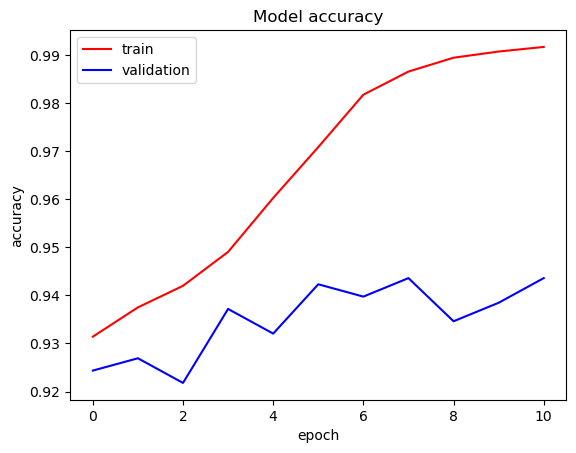

In [22]:
# displaying the model accuracy
plt.plot(history.history['accuracy'], label='train', color="red")
plt.plot(history.history['val_accuracy'], label='validation', color="blue")
plt.title('Model accuracy')
plt.legend(loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

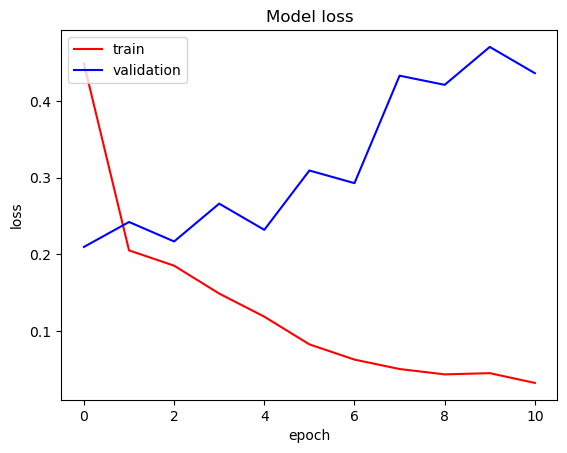

In [23]:
# displaying the model loss
plt.plot(history.history['loss'], label='train', color="red")
plt.plot(history.history['val_loss'], label='validation', color="blue")
plt.title('Model loss')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [24]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 121, 121, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 59, 59, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 222784)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [25]:
from tensorflow.keras.models import Model

# Create a new model that extracts features from the last convolutional layer
feature_extraction_model = Model(inputs=model.input, outputs=model.get_layer('flatten').output)

# Extract features from your dataset
X_train_features = feature_extraction_model.predict(X_train)
X_test_features = feature_extraction_model.predict(X_test)


25/25 [==============================] - 4s 147ms/step


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [30]:
# Feature Scaling
sc = StandardScaler()

X_train_fs = sc.fit_transform(X_train_features)
X_test_fs = sc.transform(X_test_features)

In [31]:
## NAIVE BAYES

In [32]:
from sklearn.naive_bayes import GaussianNB

In [39]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'var_smoothing': [1e-5, 1e-9] # You can adjust this range
    
}

In [40]:
nb = GaussianNB()

In [41]:
# Create the GridSearch object without cross-validation
grid_search = GridSearchCV(nb, param_grid, cv=5, verbose=2)  # Set cv=None for no cross-validation

In [42]:
grid_search.class_prior_ = [0.5, 0.5]

In [43]:
# Fit the GridSearch object to your data
grid_search.fit(X_train_fs, y_train)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ................................var_smoothing=1e-05; total time=   6.8s
[CV] END ................................var_smoothing=1e-05; total time=   6.9s
[CV] END ................................var_smoothing=1e-05; total time=   7.0s
[CV] END ................................var_smoothing=1e-05; total time=   7.1s
[CV] END ................................var_smoothing=1e-05; total time=   7.0s
[CV] END ................................var_smoothing=1e-09; total time=   7.4s
[CV] END ................................var_smoothing=1e-09; total time=   7.2s
[CV] END ................................var_smoothing=1e-09; total time=   7.1s
[CV] END ................................var_smoothing=1e-09; total time=   7.1s
[CV] END ................................var_smoothing=1e-09; total time=   7.1s


GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-05, 1e-09]}, verbose=2)

In [44]:
# Get the best estimator and evaluate it
best_nb = grid_search.best_estimator_
y_test_pred_nb = best_nb.predict(X_test_fs)
accuracy_nb = accuracy_score(y_test, y_test_pred_nb)
print("Best Gaussian Naive Bayes Parameters:", grid_search.best_params_)
print("Accuracy: {:.2f}%".format(accuracy_nb * 100))

Best Gaussian Naive Bayes Parameters: {'var_smoothing': 1e-09}
Accuracy: 88.33%


In [ ]:
y_train_pred = best_nb.predict(X_train)
accuracy_train_nb = accuracy_score(y_train, y_train_pred)


In [ ]:
accuracy_values = [accuracy_train_nb, accuracy_nb]


In [ ]:
colors = ['steelblue', 'salmon']
labels = ['Training', 'Test']



plt.figure(figsize=(4, 4))
plt.bar(labels, accuracy_values, color=colors)

for i in range(len(accuracy_values)):
    plt.text(i, accuracy_values[i] + 0.05, '{:.2f}%'.format(accuracy_values[i] * 100), ha='center', va='center')


plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy of Gaussian Naive Bayes Model')
plt.show()


In [ ]:
## for SVM

In [45]:
from sklearn.svm import SVC

In [46]:
# Hyperparameter Tuning using GridSearchCV
param_grid_svm = {'C': [5], 'gamma': ['auto'], 'kernel': ['rbf']}

In [47]:
# Train the SVM model
svm = SVC()
grid_search = GridSearchCV(svm, param_grid_svm, cv=5, verbose=2)
grid_search.fit(X_train_fs, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ........................C=5, gamma=auto, kernel=rbf; total time=12.8min
[CV] END ........................C=5, gamma=auto, kernel=rbf; total time=16.2min
[CV] END ........................C=5, gamma=auto, kernel=rbf; total time=13.3min
[CV] END ........................C=5, gamma=auto, kernel=rbf; total time=13.1min
[CV] END ........................C=5, gamma=auto, kernel=rbf; total time=14.6min


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [5], 'gamma': ['auto'], 'kernel': ['rbf']},
             verbose=2)

In [48]:
# # Get the best estimator and evaluate it
best_svm = grid_search.best_estimator_
y_test_pred_svm = best_svm.predict(X_test_fs)
accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
print("Best SVM Parameters:", grid_search.best_params_)
print("Accuracy: {:.2f}%".format(accuracy_svm * 100))

Best SVM Parameters: {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 92.82%


In [ ]:
## for KNN

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5]  # You can adjust this range
}

In [51]:
# Create the KNN model
knn = KNeighborsClassifier(n_neighbors = 5, weights='uniform', p = 2, algorithm='auto') # metric = 'minkowski',

In [52]:
# Create the GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=2)

# Fit the GridSearchCV object to your data
grid_search.fit(X_train_fs, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................................n_neighbors=3; total time=  10.1s
[CV] END ......................................n_neighbors=3; total time=   9.9s
[CV] END ......................................n_neighbors=3; total time=  10.1s
[CV] END ......................................n_neighbors=3; total time=   9.9s
[CV] END ......................................n_neighbors=3; total time=   9.8s
[CV] END ......................................n_neighbors=5; total time=  10.5s
[CV] END ......................................n_neighbors=5; total time=  10.5s
[CV] END ......................................n_neighbors=5; total time=   9.8s
[CV] END ......................................n_neighbors=5; total time=  10.1s
[CV] END ......................................n_neighbors=5; total time=  10.2s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5]}, verbose=2)

In [53]:
# Get the best estimator and evaluate it
best_knn = grid_search.best_estimator_
y_test_pred_knn = best_knn.predict(X_test_fs)
accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print("Best KNN Parameters:", grid_search.best_params_)
print("Accuracy: {:.2f}%".format(accuracy_knn * 100))

Best KNN Parameters: {'n_neighbors': 5}
Accuracy: 92.56%


In [ ]:
## Random forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [None, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False]
}


In [56]:
# Create the Random Forest model
rf = RandomForestClassifier()

In [57]:
# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5, verbose=2, error_score='raise')

# Fit the GridSearchCV object to your data
grid_search.fit(X_train_fs, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  33.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  36.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  36.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  37.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  36.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  40.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_esti

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120; total time=  44.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  27.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  26.8s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  28.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  31.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  29.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  34.5s
[CV] END bootstrap=False, max_de

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=120; total time=  34.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=120; total time=  31.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  21.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  20.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  22.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  23.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  21.2s
[CV] END bootstrap=False, m

[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=120; total time=   3.6s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=120; total time=   3.6s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=120; total time=   3.7s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   2.5s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, ma

[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=   2.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=   2.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=   2.2s
[CV] END bootstrap=False, max_

[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=  36.5s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=  36.8s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=  36.9s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=  35.8s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=  24.0s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=  24.5s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80; total time=  24.9s
[CV] END bootstrap=False, max_depth=15, m

[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=120; total time=  34.6s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=120; total time=  33.1s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=120; total time=  34.5s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=120; total time=  34.7s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80; total time=  20.5s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80; total time=  20.8s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80; total time=  20.8s
[CV] END bootstrap=False, max_depth=15, 

[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=120; total time=   4.0s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=120; total time=   4.0s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=120; total time=   3.9s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=120; total time=   3.2s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   2.5s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   2.5s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=80; total time=   2.6s
[CV] END bootstrap=False, max_depth=15, max_

[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=120; total time=   3.3s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=120; total time=   3.0s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=120; total time=   3.0s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=120; total time=   3.0s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=15, m

[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  29.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  33.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80; total time=  33.0s
[CV] END bootstrap=False, max_depth=20, 

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120; total time=  40.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120; total time=  37.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120; total time=  42.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=120; total time=  41.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  28.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  26.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  25.6s
[CV] END bootstrap=False, max_depth=20, max_

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=120; total time=  31.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=120; total time=  31.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=120; total time=  34.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=120; total time=  32.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  21.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  21.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80; total time=  21.8s
[CV] END bootstrap=False, max_depth=20, m

[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=120; total time=   3.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=120; total time=   3.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=120; total time=   3.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=120; total time=   3.4s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=20, 

[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   2.8s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   2.8s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   2.8s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   2.9s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=20, max_

GridSearchCV(cv=5, error_score='raise', estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False], 'max_depth': [None, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [80, 100, 120]},
             verbose=2)

In [58]:
# Get the best estimator and evaluate it
best_rf = grid_search.best_estimator_
y_test_pred_rf = best_rf.predict(X_test_fs)
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print("Best Random Forest Parameters:", grid_search.best_params_)
print("Accuracy: {:.2f}%".format(accuracy_rf * 100))

Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 120}
Accuracy: 95.64%


In [ ]:
# GRADIENT BOOSTING

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

In [60]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {'n_estimators': [100, 150],
              'learning_rate': [0.1],
              'max_depth': [5],
              'max_features': ['log2'],
              'loss': ['log_loss'],
              'subsample': [0.5, 1]
            }

In [61]:
gb = GradientBoostingClassifier()

In [62]:
# Create the GridSearch object without cross-validation
grid_search = GridSearchCV(gb, param_grid, cv=5, verbose=2, error_score='raise')  # Set cv=None for no cross-validation

# Fit the GridSearch object to your data
grid_search.fit(X_train_fs, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END learning_rate=0.1, loss=log_loss, max_depth=5, max_features=log2, n_estimators=100, subsample=0.5; total time=   2.9s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=5, max_features=log2, n_estimators=100, subsample=0.5; total time=   3.2s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=5, max_features=log2, n_estimators=100, subsample=0.5; total time=   3.3s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=5, max_features=log2, n_estimators=100, subsample=0.5; total time=   3.2s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=5, max_features=log2, n_estimators=100, subsample=0.5; total time=   3.2s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=5, max_features=log2, n_estimators=100, subsample=1; total time=   4.4s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=5, max_features=log2, n_estimators=100, subsample=1; total time=   4.6s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=5,

GridSearchCV(cv=5, error_score='raise', estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1], 'loss': ['log_loss'],
                         'max_depth': [5], 'max_features': ['log2'],
                         'n_estimators': [100, 150], 'subsample': [0.5, 1]},
             verbose=2)

In [63]:
# Get the best estimator and evaluate it
best_gb = grid_search.best_estimator_
y_test_pred_gb = best_gb.predict(X_test_fs)
accuracy_gb = accuracy_score(y_test, y_test_pred_gb)
print("Best Gaussian Naive Bayes Parameters:", grid_search.best_params_)
print("Accuracy: {:.2f}%".format(accuracy_gb * 100))

Best Gaussian Naive Bayes Parameters: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 150, 'subsample': 0.5}
Accuracy: 95.38%


In [ ]:
## RANDOM FOREST

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [None, 20, 25],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': [ 'sqrt', 'log2'],
    'bootstrap': [False]
}


In [66]:
# Create the Random Forest model
rf = RandomForestClassifier()

In [67]:
# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5, verbose=2, error_score='raise')

In [68]:
# Fit the GridSearchCV object to your data
grid_search.fit(X_train_fs, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  28.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  27.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  27.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  29.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  30.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  35.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estim

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=  31.0s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=False, max_d

[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  26.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  25.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  27.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  28.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  27.8s
[CV] END bootstrap=False, max_depth=20, 

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=  34.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=  29.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=20, max_

[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   2.5s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  27.8s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  28.4s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  29.3s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  29.8s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=  29.3s
[CV] END bootstrap=False, max_depth=25, max_

[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=  35.3s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=  31.1s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.4s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   2.3s
[CV] END bootstrap=False, max_depth=25, max_

[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   2.6s
[CV] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=120; total time=   2.6s


GridSearchCV(cv=5, error_score='raise', estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False], 'max_depth': [None, 20, 25],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 10],
                         'n_estimators': [80, 100, 120]},
             verbose=2)

In [69]:
# Get the best estimator and evaluate it
best_rf = grid_search.best_estimator_
y_test_pred = best_rf.predict(X_test_fs)
accuracy = accuracy_score(y_test, y_test_pred)
print("Best Random Forest Parameters:", grid_search.best_params_)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 80}
Accuracy: 95.64%
